<a href="https://colab.research.google.com/github/kiteday/AI_contents/blob/main/d_customLoad_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch.autograd import Variable

from PIL import Image

# 1) test data로 불러올 csv파일, image 폴더 지정

In [2]:
batch_size = 2
imgsize =256

In [3]:
import os
import pandas as pd

"""
============================================
MyGetInfoFromCsv
============================================
* csv 파일 읽어서 클래스 및 데이터 정보 알아내기
* 호출 방법
classes, class_to_idx, length, total_flist, labels = read_csv

* 입력변수
i_csv_path : csv 파일 경로
i_img_path : 실ㅊ 이미지들이 저장된 경로 (폴더)
i_key_field : 클래스로 삼을 필드

교수님 함수
"""
def MyGetInfoFromCsv(i_csv_path, i_img_path, i_key_field='technique'):
  cwd = os.getcwd()
  with open(i_csv_path, encoding='windows-1252') as csvfile:
    info = pd.read_csv(csvfile)

    classes = sorted(set(info[i_key_field]))
    class_to_idx = {}
    length = 0
    total_file_list=[]
    total_label = []

    for i, c in enumerate(classes):
      class_to_idx.update({c:i})
    length = len(info)

    for i in range(length):
      key_val = info[i_key_field][i]
      total_file_list.append(i_img_path + info['image_id'][i] + ".jpg")
      total_label.append(class_to_idx[key_val])

    return classes, class_to_idx, length, total_file_list, total_label

In [4]:
csv_path = "/content/drive/MyDrive/AI_content/wiki/" + "wikipaintings_oct2013_technique+test+15.csv"
img_path = "/content/drive/MyDrive/AI_content/wiki/" +"images/"
classes, class_to_idx, length, flist, label = MyGetInfoFromCsv(csv_path, img_path, "technique")
print(classes)
print(class_to_idx)
print(length)
print(flist[:3])
print(label[:3])

['oil', 'pastel', 'pencil', 'watercolor']
{'oil': 0, 'pastel': 1, 'pencil': 2, 'watercolor': 3}
563
['/content/drive/MyDrive/AI_content/wiki/images/john-william-waterhouse_ophelia-1894.jpg', '/content/drive/MyDrive/AI_content/wiki/images/yves-tanguy_death-awaiting-his-family-1927.jpg', '/content/drive/MyDrive/AI_content/wiki/images/john-french-sloan_stein-profile-foreign-girl-1905.jpg']
[0, 0, 0]


In [5]:
"""
==========================
MyImageCsv
==========================
* csv 파일로 읽은 영상을 자동으로 잘라주기
* 입력변수
  i_csv_path : .csv파일 경로
  i_img_path : 실체 이미지들이 저장된 경로
  i_key_field : 클래스로 삼을 필드
  i_imgsize : 기준이 되는 이미지 크기
    - rescale의 최대 배수의 사이즈가 네트워크가 안터지는 최대 사이즈 이하여야 함
  i_DataAug: data augmentation 연산 추가 여부. 보통 트레인 데이터에 많이 사용됨.
"""
class MyImageCsv(Dataset):
  def __init__(self, i_csv_path, i_img_path, i_key_field,
               i_imgsize=128,
               i_DataAug=False, transform=transforms.ToTensor()):
    self.classes, self.class_to_idx, self.length, self.filst, self.labels = MyGetInfoFromCsv(i_csv_path, i_img_path, i_key_field)
    self.imgsize = i_imgsize
    self.i_DataAug = i_DataAug
    self.transform=transform

  def __len__(self):
    return self.length # 이 path에 있는 모든 폴더의 모든 이미지 개수

  def __getitem__(self, idx):
    max_size = self.imgsize
    # original image
    img = Image.open(self.filst[idx])

    # 예외처리-mode
    if img.mode != "RGB":
      img = img.convert(mode="RGB")

    # 이미지 조정
    img = self.transform(img)

    # label
    label = self.labels[idx]

    return img, label

# 2) test 데이터 정보 출력

In [6]:
csv_path = "/content/drive/MyDrive/AI_content/wiki/" + "wikipaintings_oct2013_technique+test+15.csv"
img_path = "/content/drive/MyDrive/AI_content/wiki/" +"images/"

my_test = MyImageCsv(csv_path, img_path, 'technique',
                     i_imgsize=imgsize, i_DataAug=True)

nclass = len(my_test.classes)
print("# of classes(클래스 개수): %d" %nclass)

print("클래스 이름 : ", my_test.classes)
print("클래스별 인덱스 : ", my_test.class_to_idx)
print("my_train 개수 : ", my_test.__len__())

# of classes(클래스 개수): 4
클래스 이름 :  ['oil', 'pastel', 'pencil', 'watercolor']
클래스별 인덱스 :  {'oil': 0, 'pastel': 1, 'pencil': 2, 'watercolor': 3}
my_train 개수 :  563


# test 데이터 그리기

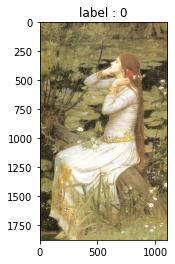

(1879, 1100, 3)


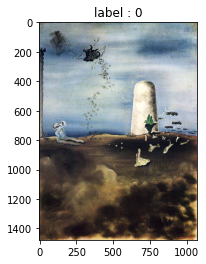

(1478, 1069, 3)


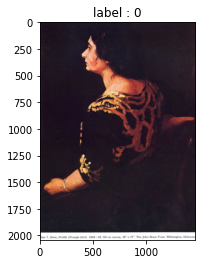

(2042, 1462, 3)


In [7]:
for i in range(3):
  img = my_test[i][0].numpy()
  img = np.transpose(img, (1,2,0))

  plt.title("label : %d" %my_test[i][1])
  plt.imshow(img)
  plt.show()

  print(img.shape)

# 3) 데이터 로드하기

In [8]:
my_test = MyImageCsv(csv_path, img_path, 'technique',
                     i_imgsize=imgsize,
                     i_DataAug=True,
                     transform=transforms.Compose([transforms.Resize((imgsize, imgsize)),
                                                   transforms.ToTensor() ]))
my_loader = DataLoader(my_test, batch_size=batch_size,
                      shuffle=False, num_workers=2)

# 4) 데이터 로더 사용하기

[0]
한 번에 로드되는 데이터 크기: 2
torch.Size([2, 3, 256, 256])
torch.Size([2])


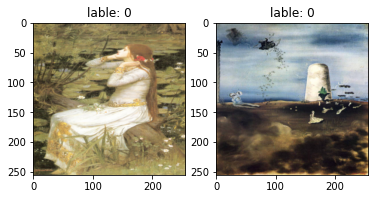

[1]
한 번에 로드되는 데이터 크기: 2
torch.Size([2, 3, 256, 256])
torch.Size([2])


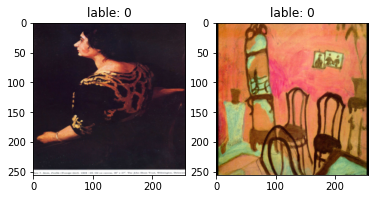

In [9]:
n = 2 # 샘플로 그려볼 데이터 개수

for i, [imgs, labels] in enumerate(my_loader):  # batch_size 만큼
  if i>1:
    break

  print("[%d]" %i)
  print("한 번에 로드되는 데이터 크기:", len(imgs))

  x = Variable(imgs).cuda()
  y_ = Variable(labels).cuda()

  print(x.shape)
  print(y_.shape)

  # 그리기
  for j in range(n):
    img = imgs[j].numpy() # image 타입-> numpy로 변환 (3, width, height)
    img = np.transpose(img, (1,2,0)) # (3, width, height) -> (width, heigh, 3)

    plt.subplot(1, n, j+1) # (1,3) 형태 플랏의 j번떄 위치에 그림
    plt.imshow(img)
    plt.title("lable: %d" %labels[j])
  plt.show()